<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="UTF-8" />
        <meta http-equiv="X-UA-Compatible" content="IE=edge" />
        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
        <title>UAS NLP</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #f0f0f0;
                margin: 0;
                padding: 0;
            }
            .container {
                text-align: center;
                margin-top: 50px;
            }
            h1 {
                color: #fff; /* Adjusted color for dark mode */
                font-size: 36px;
                margin-bottom: 10px;
            }
            h2 {
                color: #ccc; /* Adjusted color for dark mode */
                font-size: 28px;
                margin-bottom: 20px;
            }
            .members {
                font-size: 20px;
                line-height: 1.6;
                margin-top: 20px;
            }
            .member {
                display: block;
                margin-bottom: 10px;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Ujian Akhir Semester</h1>
            <h2>IBDA3322 / Natural Language Processing</h2>
            <h2>English To Indonesia Machine Translation Using mBART-50</h2>
            <p class="members">
                <span class="member">Jennifer Atalya (202000208)</span>
                <span class="member">Renata Valencia (202001021)</span>
                <span class="member">Stefannus Christian (202000138)</span>
            </p>
        </div>
    </body>
</html>

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
# Import libraries
from transformers import (
    MBart50TokenizerFast,
    MBartForConditionalGeneration,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
)
import csv
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import evaluate
from datasets import load_dataset

# Define Global Variables

In [29]:
# Define training parameters
TRAIN: bool = True # Set to True to train the model
SEED = 42  # Random seed for reproducibility

# Define model and data paths
MODEL_PATH = "model/mbart-large-50-one-to-many-mmt-finetuned-en-to-id"
PREFIX = ""  # Prefix to add before source language text
SOURCE_LANG = "en"  # Source language
TARGET_LANG = "id"  # Target language
MAX_INPUT_LENGTH = 128  # Maximum length of input sequence
MAX_TARGET_LENGTH = 128  # Maximum length of target sequence

TRAINING_RESULTS_DIRECTORY_BASE_PATH = "./training_results/"
TRAINING_RESULTS_FILENAME = "training_results.csv"
LOG_RESULTS_FILENAME = "log.pkl"

TRAINING_RESULTS_PATH = os.path.join(TRAINING_RESULTS_DIRECTORY_BASE_PATH, TRAINING_RESULTS_FILENAME)
LOG_RESULTS_PATH = os.path.join(TRAINING_RESULTS_DIRECTORY_BASE_PATH, LOG_RESULTS_FILENAME)

RAW_DATASETS_PATH = "uas_cache/raw_datasets.pkl"
TOKENIZER_PATH = "uas_cache/tokenizer.pkl"

if TRAIN:
    print("RUNNING IN TRAIN MODE!")
else:
    print("RUNNING ON TEST MODE!")

print(f'Will save training results csv to {TRAINING_RESULTS_PATH}')
print(f'Will save log results (log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log) to {LOG_RESULTS_PATH}')

RUNNING ON TEST MODE!
RUNNING ON LOCAL LAPTOP!

Will save training results csv to ./training_results/training_results.csv
Will save log results (log_history, bleu_log, meteor_log, eval_log) to ./training_results/log.pkl


# Load Raw Datasets

In [3]:
# Load dataset
model_mbart = 'facebook/mbart-large-50-one-to-many-mmt'

if not os.path.exists(RAW_DATASETS_PATH):
    raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
    with open(RAW_DATASETS_PATH, "wb") as f:
        pickle.dump(raw_datasets, f)

else:
    # Load the raw datasets using pickle
    with open(RAW_DATASETS_PATH, "rb") as f:
        raw_datasets = pickle.load(f)

# View dataset information
display(raw_datasets)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [4]:
# Load tokenizer for the pre-trained model
tokenizer = MBart50TokenizerFast.from_pretrained(
    model_mbart, src_lang="en_XX", tgt_lang="id_ID"
)

In [5]:
def remove_extra_spaces(text :str) -> str:
    """
    Removes extra spaces from a string using regular expression.

    Args:
    - text (str): The input text with extra spaces.

    Returns:
    - str: The text with extra spaces removed.
    """
    # Use regular expression to substitute multiple spaces with a single space
    cleaned_text = re.sub(' +', ' ', text)
    return cleaned_text.strip()

def preprocess_function(examples):
    """
    Preprocess data examples:
        - Add prefix to source language text
        - Lowercase source language text
        - Remove extra spaces from source and target language text
        - Encode text with tokenizer
    """
    # Lowercase source language text and remove extra spaces
    inputs = [PREFIX + remove_extra_spaces(ex[SOURCE_LANG]) for ex in examples["translation"]]
    # Lowercase target language text and remove extra spaces
    targets = [remove_extra_spaces(ex[TARGET_LANG]) for ex in examples["translation"]]

    model_inputs = tokenizer(
        inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    # Set tokenizer for target language
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=MAX_TARGET_LENGTH, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
# Preprocess dataset
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

# Split datasets into train and validation sets
train_tokenized_dataset = tokenized_datasets["train"]
eval_tokenized_dataset = tokenized_datasets["validation"]
number_of_train_tokenized_data = len(train_tokenized_dataset)
number_of_eval_tokenized_data = len(eval_tokenized_dataset)
print(f"Number of train tokenized data: {number_of_train_tokenized_data}")
print(f"Number of eval tokenized data: {number_of_eval_tokenized_data}\n")

PERCENTAGE_OF_TRAIN_TOKENIZED_DATA_TO_FINEDTUNED = 0.25
NUMBER_OF_TRAINING_DATA_TO_FINETUNED = int(
    PERCENTAGE_OF_TRAIN_TOKENIZED_DATA_TO_FINEDTUNED * number_of_train_tokenized_data
)  # Limit data used for fine-tuning

# Select a small subset of data for fine-tuning (for faster training)
small_train_dataset = train_tokenized_dataset.shuffle(
    seed=SEED).select(range(NUMBER_OF_TRAINING_DATA_TO_FINETUNED))
shuffled_eval_dataset = eval_tokenized_dataset.shuffle(seed=SEED)

print(f"Number of small_train_dataset {len(small_train_dataset)}")

Number of train tokenized data: 1000000
Number of eval tokenized data: 2000

Number of small_train_dataset 250000


In [9]:
# Load pre-trained model (make sure to use 'cuda' for GPU training)
model = MBartForConditionalGeneration.from_pretrained(model_mbart).cuda()

In [10]:
# Freeze all layers except the decoder's last layers
count = 0
for param in model.get_encoder().parameters():
    param.requires_grad = False
    count += 1

print(f"freezes {count} layers")

freezes 198 layers


In [11]:
# Define training hyperparameters
hyperparameters = {
    'learning_rate': 2e-5, # Default is 5e-5
    'batch_size': 16, # Default is 8
    'num_epochs': 5 # Default is 3
}

args = Seq2SeqTrainingArguments(
    # Create a name for your fine-tuned model
    MODEL_PATH,
    # Evaluate the model after every epoch
    evaluation_strategy="epoch",
    # Save the model after every epoch
    save_strategy="epoch",
    # Set learning rate from hyperparameters
    learning_rate=hyperparameters["learning_rate"],
    # Batch size for training on a single device
    per_device_train_batch_size=hyperparameters["batch_size"],
    # Batch size for evaluation on a single device
    per_device_eval_batch_size=hyperparameters["batch_size"],
    # Weight decay to avoid overfitting
    weight_decay=0.01,  # Default is 0
    # Limit number of saved models during training
    save_total_limit=hyperparameters["num_epochs"],
    # Set the total number of training epochs
    num_train_epochs=hyperparameters["num_epochs"],
    # Generate text with beam search during evaluation
    predict_with_generate=True,
    load_best_model_at_end=True,
)

In [12]:
# Create a data collator to prepare batches for training and evaluation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
metric = evaluate.load('sacrebleu')
rouge = evaluate.load('rouge')

def postprocess_text(preds, labels):
   preds = [pred.strip() for pred in preds]
   labels = [[label.strip()] for label in labels]
   return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Compute rouge
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    result = {'bleu' : result['score']}
    result["rouge1"] = rouge_result["rouge1"]
    result["rouge2"] = rouge_result["rouge2"]
    result["rougeL"] = rouge_result["rougeL"]
    result["rougeLsum"] = rouge_result["rougeLsum"]

    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
if not os.path.exists(TRAINING_RESULTS_PATH):
    os.makedirs(TRAINING_RESULTS_PATH)

if TRAIN:
    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=small_train_dataset,
        eval_dataset=shuffled_eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    trainer.save_model(MODEL_PATH)

    log_history = pd.DataFrame(trainer.state.log_history)
    bleu_log = log_history["eval_bleu"].dropna().to_list()
    eval_log = log_history["eval_loss"].dropna().to_list()
    rouge1_log = log_history["eval_rouge1"].dropna().to_list()
    rouge2_log = log_history["eval_rouge2"].dropna().to_list()
    rougeL_log = log_history["eval_rougeL"].dropna().to_list()
    rougeLsum_log = log_history["eval_rougeLsum"].dropna().to_list()

    # Save the variables using pickle
    with open(LOG_RESULTS_PATH, "wb") as f:
        pickle.dump((log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log), f)

else:
    # Load the saved variables using pickle
    with open(LOG_RESULTS_PATH, "rb") as f:
        log_history, bleu_log, rouge1_log, rouge2_log, rougeL_log, rougeLsum_log, eval_log = pickle.load(f)

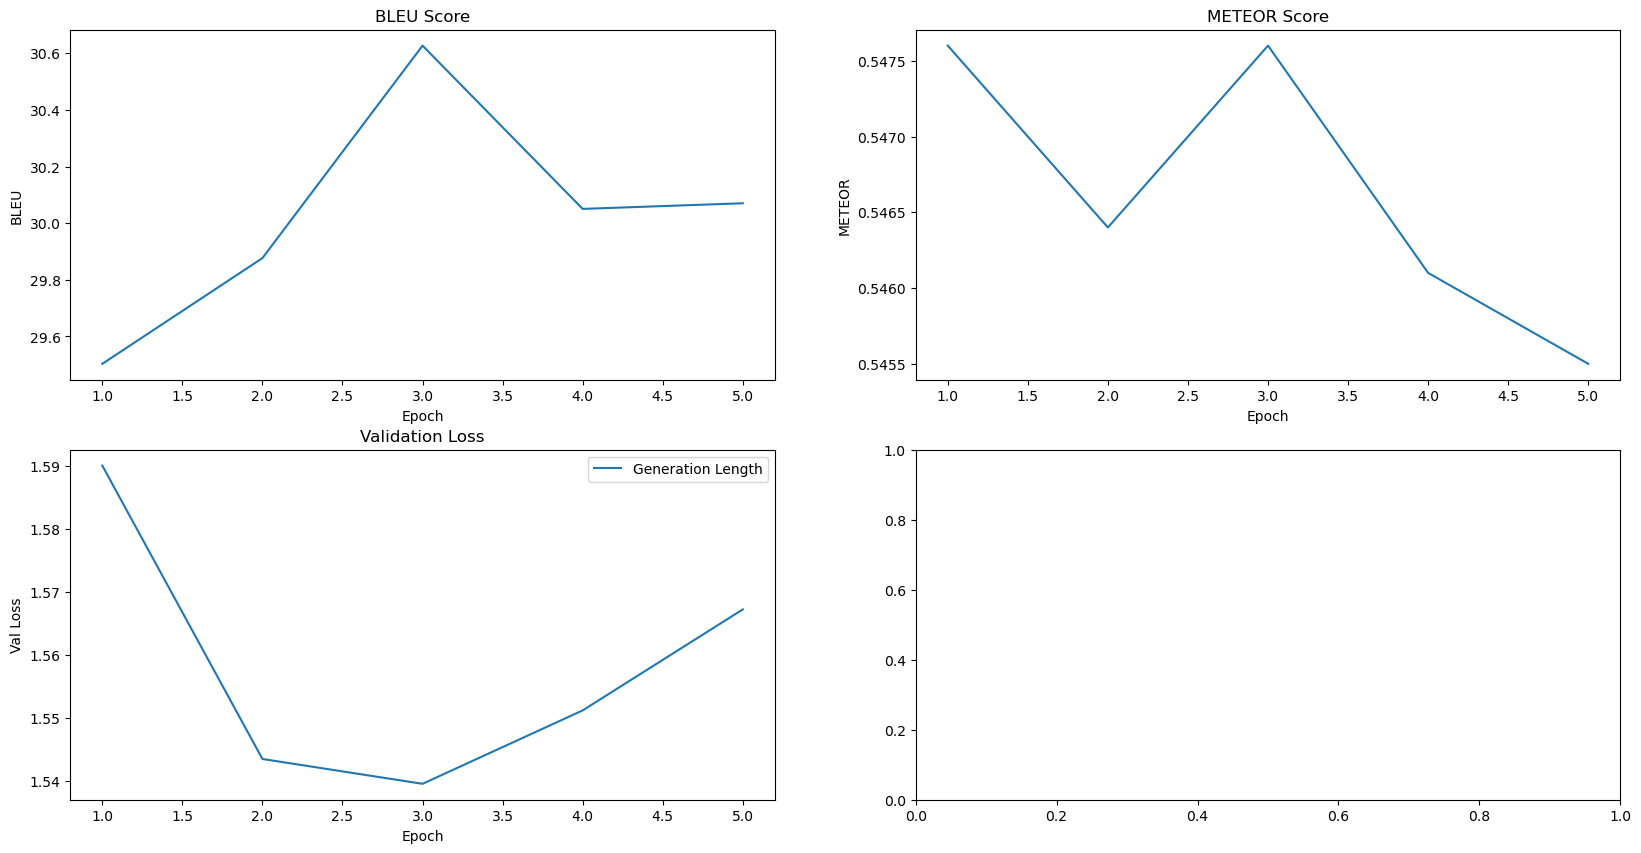

In [22]:
fig, ax = plt.subplots(4, 2, figsize=(20,25))
plt.subplot(4, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 4)
plt.plot(range(len(rouge1_log)), rouge1_log, label='Rouge1 Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 5)
plt.plot(range(len(rouge2_log)), rouge2_log, label='Rouge2 Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 6)
plt.plot(range(len(rougeL_log)), rougeL_log, label='RougeL Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(4, 2, 7)
plt.plot(range(len(rougeLsum_log)), rougeLsum_log, label='RougeLsum Score')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [16]:
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open(TRAINING_RESULTS_PATH, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)

In [30]:
print("Loading tokenizer and model...\n")
tokenizer = MBart50TokenizerFast.from_pretrained(os.path.join(MODEL_PATH, "checkpoint-46875"), src_lang="en_XX")
model = MBartForConditionalGeneration.from_pretrained(
    os.path.join(MODEL_PATH, "checkpoint-46875")).cuda()

src_text =  """I want to tell you something, but it's a secret. Promise not to tell. I got my driver's license on the second time I tried to pass the driver's test. I don't think I can get you to understand how easy to get driver's license. When I'm good at driving, I'll teach you."""

print(f"English Text To Translate: {src_text}\n")
print("Replacing special characters except comma with with periods(.)\n")
src_text = src_text.replace("!",".").replace(":",".")

print("Normalizing english text to translate...")
src_text = remove_extra_spaces(src_text)
print(f"Normalized text: {src_text}\n")

print("Tokenizing text to translate...")
sentences = [(sentence+". ").strip() for sentence in src_text.split(".") if len(sentence) > 0]
print(f"Tokenized results: {sentences}\n")

translation_results = ""
for sentence in sentences:
    print(f'Translating {sentence}...')
    model_inputs = tokenizer(sentence, return_tensors="pt").to("cuda")

    generated_tokens = model.generate(
        **model_inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["id_ID"],
    )

    translation = tokenizer.batch_decode(
        generated_tokens, skip_special_tokens=True)
    sentence_translate_result = translation[0].strip()
    print(f'Translate result: {sentence_translate_result}\n')
    translation_results += sentence_translate_result

print("Final Translation Results:")
final_translations = translation_results.replace(".",". ").strip()
print(final_translations)

Loading tokenizer and model...

English Text To Translate: I want to tell you something, but it's a secret. Promise not to tell. I got my driver's license on the second time I tried to pass the driver's test. I don't think I can get you to understand how easy to get driver's license. When I'm good at driving, I'll teach you.

Replacing special characters except comma with with periods(.)

Normalizing english text to translate...
Normalized text: I want to tell you something, but it's a secret. Promise not to tell. I got my driver's license on the second time I tried to pass the driver's test. I don't think I can get you to understand how easy to get driver's license. When I'm good at driving, I'll teach you.

Tokenizing text to translate...
Tokenized results: ["I want to tell you something, but it's a secret.", 'Promise not to tell.', "I got my driver's license on the second time I tried to pass the driver's test.", "I don't think I can get you to understand how easy to get driver's li